## Set up simple flow

Move current directory to project root

In [1]:
%load_ext autoreload
%autoreload 2

import os
from pathlib import Path

if 'project_root' not in dir():
    project_root = Path.cwd().parent
    
os.chdir(project_root)

Toy dataset

In [2]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from model_zoo.datasets.generated import Sphere
from model_zoo.datasets.utils import OmitLabels

dataset = Sphere('', 'test', manifold_dim=1, ambient_dim=2, mu=np.array([-3, -3]))
data_vec = dataset.x
dataloader = DataLoader(OmitLabels(dataset), batch_size=50)

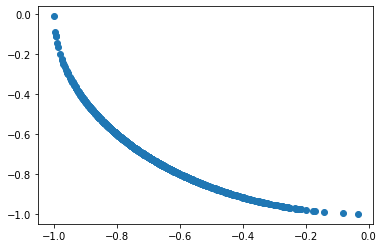

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(dataset.x[:, 0], dataset.x[:, 1])

Construct a flow consisting of one simple linear transformation

In [4]:
from torch import optim
from model_zoo.density_estimator.flow import NormalizingFlow

flow = NormalizingFlow(
    dim=2,
    transform=[{
        'class_path': 'nflows.transforms.lu.LULinear',
        'init_args': {
            'features': 2
        }
    }],
)

optimizer = optim.Adam(flow.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.LambdaLR(
    optimizer,
    lambda step: 1
)

flow.optimizer = optimizer
flow.lr_scheduler = scheduler

Train the flow

/home/brendan/anaconda3/envs/ood/lib/python3.9/site-packages/nflows/transforms/lu.py:80: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2191.)
  outputs, _ = torch.triangular_solve(


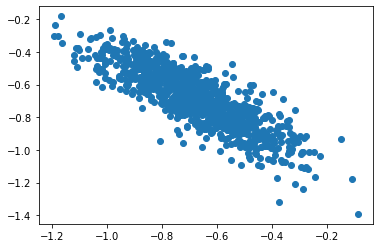

In [5]:
for epoch in range(1000):
    for batch in dataloader:
        flow.train_batch(batch)
    
gen_sample = flow.sample(1000).detach()
plt.scatter(gen_sample[:, 0], gen_sample[:, 1])

Evaluate 

In [6]:
from ood.methods.linear_approximations.latent_statistics import EllipsoidCDFStatsCalculator
from ood.methods.linear_approximations.encoding_model import EncodingFlow


ellipsoid_calc = EllipsoidCDFStatsCalculator(
    flow, EncodingFlow, {'use_functorch': True, 'use_forward_mode': False, 'use_vmap': True})
ellipsoid_samples = ellipsoid_calc.sample(0.01, dataloader, 1000)

sampling from batch 29: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2460.00it/s]


sampling from batch 58: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2452.39it/s]


sampling from batch 87: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2480.13it/s]


sampling from batch 116: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2451.60it/s]


sampling from batch 145: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2451.67it/s]


sampling from batch 174: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2454.53it/s]


sampling from batch 203: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2425.33it/s]


sampling from batch 232: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2449.04it/s]


sampling from batch 261: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2381.72it/s]


sampling from batch 290: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2399.90it/s]


sampling from batch 319: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2381.93it/s]


sampling from batch 348: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1955.88it/s]


sampling from batch 377: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1948.60it/s]


sampling from batch 406: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1955.99it/s]


sampling from batch 435: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2061.59it/s]


sampling from batch 464: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2441.35it/s]


sampling from batch 493: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2385.04it/s]


sampling from batch 522: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2408.64it/s]


sampling from batch 551: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2409.04it/s]


sampling from batch 580: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2414.99it/s]


sampling from batch 609: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2412.77it/s]


sampling from batch 638: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2415.55it/s]


sampling from batch 667: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2392.63it/s]


sampling from batch 696: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2411.18it/s]


sampling from batch 725: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2384.37it/s]


sampling from batch 754: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2405.80it/s]


sampling from batch 783: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2398.34it/s]


sampling from batch 812: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2412.27it/s]


sampling from batch 841: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2399.73it/s]


sampling from batch 870: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2416.86it/s]


sampling from batch 899: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2414.55it/s]


sampling from batch 928: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2408.88it/s]


sampling from batch 957: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2374.30it/s]


sampling from batch 986: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2406.79it/s]


sampling from batch 1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2413.59it/s]


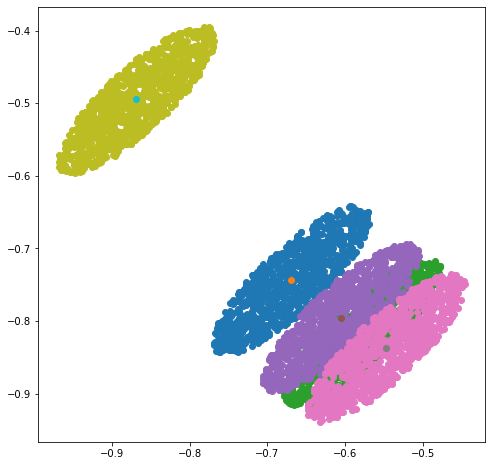

In [7]:
plt.figure(figsize=(8, 8))
for index in range(5):
    plt.scatter(ellipsoid_samples[index][:, 0], ellipsoid_samples[index][:, 1])
    plt.scatter(data_vec[index][:1], data_vec[index][1:]) 